In [1]:
%matplotlib inline

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
#setting the seed for reproducibility
#seed = 10110
seed = 12061204
numpy.random.seed(seed)

#load the dataset
dataframe = pandas.read_csv("F:/UOSEST/Data/Lyle-pparg-ligand/input/pparg_ligand_data(0,1).csv")
# dataframe = pandas.read_csv("F:/UOSEST/Data/Lyle-pparg-ligand/input/SR-MMP.csv")


In [ ]:
dataframe = dataframe.dropna(axis=0)

In [3]:
dataframe = shuffle(dataframe)

In [4]:
mols = []
fps = []

#get molecules and then get fingerprints from those
for index, row in dataframe.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    mols.append(mol)
    fps.append(fp)

#Convert the RDKit vectors into numpy arrays
#Based on: http://www.rdkit.org/docs/Cookbook.html#using-scikit-learn-with-rdkit
np_fps = []
for fp in fps:
    arr = numpy.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    np_fps.append(arr)

np_fps_array = numpy.array(np_fps)
X = np_fps_array
Y = dataframe['Type'].values

In [ ]:
# from imblearn.under_sampling import *
# X_under, Y_under = RandomUnderSampler(random_state=0).fit_sample(X, Y)

In [ ]:
# tmp = [[x,y] for x, y in zip(X_under, Y_under)]

In [ ]:
tmp = shuffle(tmp)

In [ ]:
X= [n[0] for n in tmp]
Y = [n[1] for n in tmp]

In [5]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators = 76, random_state=11) # 76개의 트리를 사용한 랜덤 포레스트

In [6]:
n = len(X)
p = 0.8
X_test = X[int(n*p):]
Y_test = Y[int(n*p):]

X_train = X[:int(n*p)]
Y_train = Y[:int(n*p)]

In [7]:
len(X_train)

636

In [8]:
estimator.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=76,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [9]:
pred_y = estimator.predict(X_test)

In [10]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test,pred_y)

In [11]:
conf_mat

array([[148,   0],
       [ 12,   0]], dtype=int64)

# precision

In [15]:
(conf_mat[0][0])/(conf_mat[0][0]+conf_mat[1][0])

0.925

# recall

In [13]:
/(112+64)

0.36363636363636365

In [22]:
sum(sum(conf_mat))

160

# acc

In [23]:
(conf_mat[0][0] + conf_mat[1][1]) / sum(sum(conf_mat))

0.925

In [16]:
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

In [17]:
rf = estimator
x_tr = pd.DataFrame(X_train)
x_te = pd.DataFrame(X_test)
y_tr = pd.DataFrame(Y_train)
y_te = pd.DataFrame(Y_test)

              0: 0.55659


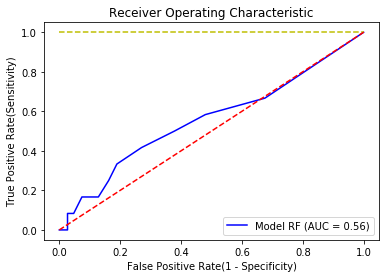

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [20]:
for target in pandas.DataFrame(y_tr).columns:
    rows_tr = np.isfinite(y_tr[target]).values #train dataset
    rows_te = np.isfinite(y_te[target]).values #test dataset
    rf = RandomForestClassifier(n_estimators=100,  n_jobs=4)
    rf.fit(x_tr[rows_tr], y_tr[target][rows_tr])
    p_te = rf.predict_proba(x_te[rows_te])
    auc_te = roc_auc_score(y_te[target][rows_te], p_te[:, 1])
    print("%15s: %3.5f" % (target, auc_te))
    graph(target)
    result_to_csv(target)

In [19]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def graph(target) :
    class_RF = y_te[target][rows_te].ravel()
    proba_RF = p_te[:,1]

    false_positive_rate_RF, true_positive_rate_RF, thresholds_RF = roc_curve(class_RF, proba_RF)
    roc_auc_RF = auc(false_positive_rate_RF,true_positive_rate_RF)
    fig = plt.figure()
    plt.title('Receiver Operating Characteristic')
    plt.xlabel('False Positive Rate(1 - Specificity)')
    plt.ylabel('True Positive Rate(Sensitivity)')


    plt.plot(false_positive_rate_RF, true_positive_rate_RF, 'b', label='Model RF (AUC = %0.2f)'% roc_auc_RF)
    plt.plot([0,1],[1,1],'y--')
    plt.plot([0,1],[0,1],'r--')

    plt.legend(loc='lower right')
    plt.show()

    fig.savefig(target+ '_RF.png')